# Product Recommendation System
Recommendation system is nothing but analyzing and predicting the user response to the options. We will be using item-based K-nearest neighbor (KNN) algorithm. In order to determine the rating of products by any user, we will find other products that have similar ratings, and based these ratings we will predict his rating on selected product. KNN finds the nearest K neighbors of each product based on similarity function, and uses the weighted means to predict the rating 

In [1]:
#import required libraries
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [2]:
#read cell phone and accessories dataset
mobile_df = pd.read_json('Cell_Phones_and_Accessories_5.json',lines=True)

In [3]:
print(mobile_df.shape)
mobile_df.head()

(194439, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600


In [4]:
#get count and mean of rating by product
count = mobile_df.groupby("asin", as_index=False).count()
mean = mobile_df.groupby("asin", as_index=False).mean()

#Merge count into dataset
mobileMerged_df = pd.merge(mobile_df, count, how='right', on=['asin'])
mobileMerged_df.head()

,asin,helpful_x,overall_x,reviewText_x,reviewTime_x,reviewerID_x,reviewerName_x,summary_x,unixReviewTime_x,helpful_y,overall_y,reviewText_y,reviewTime_y,reviewerID_y,reviewerName_y,summary_y,unixReviewTime_y
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,7,7,7,7,7,7,7,7
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,7,7,7,7,7,7,7,7
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,7,7,7,7,7,7,7,7
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,7,7,7,7,7,7,7,7
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,7,7,7,7,7,7,7,7


In [5]:
mobileMerged_df.columns

Index(['asin', 'helpful_x', 'overall_x', 'reviewText_x', 'reviewTime_x',
       'reviewerID_x', 'reviewerName_x', 'summary_x', 'unixReviewTime_x',
       'helpful_y', 'overall_y', 'reviewText_y', 'reviewTime_y',
       'reviewerID_y', 'reviewerName_y', 'summary_y', 'unixReviewTime_y'],
      dtype='object')

In [6]:
#rename column for understanding
mobileMerged_df.rename(columns={'helpful_x':'helpful', 'overall_x':'overallRating', 'reviewText_x':'reviewText', 
                          'reviewTime_x':'reviewTime', 'reviewerID_x':'reviewerId', 'reviewerName_x':'reviewrName', 
                          'summary_x':'summary', 'unixReviewTime_x':'unixReviewTime', 'helpful_y':'helpfulCount', 
                          'overall_y':'overallRatingCount', 'reviewText_y':'reviewTextCount', 
                          'reviewTime_y':'reviewTimeCount', 'reviewerID_y':'reviewerIdCount', 
                          'reviewerName_y':'reviewerNameCount', 'summary_y':'summaryCount', 'unixReviewTime_y':'unixReviewTimeCount'}, 
                 inplace=True)

In [7]:
mobileMerged_df.head()

,asin,helpful,overallRating,reviewText,reviewTime,reviewerId,reviewrName,summary,unixReviewTime,helpfulCount,overallRatingCount,reviewTextCount,reviewTimeCount,reviewerIdCount,reviewerNameCount,summaryCount,unixReviewTimeCount
0,120401325X,"[0, 0]",4,They look good and stick good! I just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,7,7,7,7,7,7,7,7
1,120401325X,"[0, 0]",5,These stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,7,7,7,7,7,7,7,7
2,120401325X,"[0, 0]",5,These are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,7,7,7,7,7,7,7,7
3,120401325X,"[4, 4]",4,Item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,7,7,7,7,7,7,7,7
4,120401325X,"[2, 3]",5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,7,7,7,7,7,7,7,7


In [8]:
#Sorting by no of reviews and get the products with more than or equal to 100 reviews
mobileMerged_df = mobileMerged_df.sort_values(by='reviewerIdCount', ascending=False)
reviews100Count = mobileMerged_df[mobileMerged_df.reviewerIdCount >= 100]
reviews100Count.head()

,asin,helpful,overallRating,reviewText,reviewTime,reviewerId,reviewrName,summary,unixReviewTime,helpfulCount,overallRatingCount,reviewTextCount,reviewTimeCount,reviewerIdCount,reviewerNameCount,summaryCount,unixReviewTimeCount
60401,B005SUHPO6,"[0, 1]",5,This product its good to protect the fragile i...,"07 13, 2013",AZ1NSCXQKRGUH,Sam,Really Good,1373673600,837,837,837,837,837,836,837,837
60498,B005SUHPO6,"[0, 0]",5,this a very good case and i recomend it to all...,"02 3, 2013",A2N6XPEZYSGAU0,tractorman6070,case,1359849600,837,837,837,837,837,836,837,837
60526,B005SUHPO6,"[0, 0]",5,"The color is great and as usual, an Otter Box ...","03 15, 2014",A30J79TFWG8XMY,Walawa05,Love it,1394841600,837,837,837,837,837,836,837,837
60527,B005SUHPO6,"[0, 0]",5,I bought an Otterbox Defender case for my iPho...,"01 23, 2013",A1EUUXDQPWPLP4,Wall St 2 Broadway,"Great case, great company",1358899200,837,837,837,837,837,836,837,837
60528,B005SUHPO6,"[0, 0]",4,I got this for my son's iPhone 4s. I thought i...,"12 16, 2013",A2CPAOK621BE07,W. Brooks,"Great protection, but bulky as hell",1387152000,837,837,837,837,837,836,837,837


### Grouping all the summary reviews by product

In [9]:
#group by summary data and save to csv
productReviewSummary = reviews100Count.groupby("asin")["summary"].apply(list)
productReviewSummary = pd.DataFrame(productReviewSummary)
productReviewSummary.to_csv("ProductReviewSummary.csv")

In [10]:
mean.head()

,asin,overall,unixReviewTime
0,120401325X,4.428571,1.384980e+09
1,3998899561,4.600000,1.387835e+09
2,6073894996,3.891892,1.376779e+09
3,7532385086,4.444444,1.344067e+09
4,7887421268,4.000000,1.354865e+09


### Dataframe with needed features

In [11]:
#include Product Id , Summary and Rating 
df_new = pd.read_csv("ProductReviewSummary.csv")
df_new = pd.merge(df_new, mean, on="asin", how='inner')
df_new = df_new[['asin','summary','overall']]
df_new.head()

,asin,summary,overall
0,B0009B0IX4,"['Solid Headset', 'Poor ergonomics mar this ot...",4.228395
1,B000S5Q9CA,['Best Micro-USB charger for Your Car. The Pr...,4.507962
2,B0013G8PTS,"['Great Battery back-up', 'Does the job, has g...",4.605960
3,B0015RB39O,"['I love these', 'Affordable', 'Would not reco...",3.628755
4,B001630QZE,"['Newcomer to bluetooth but impressed', ""Looke...",4.050000


### Text Cleaning - Summary column
For text formatting, we will use the Regex. RegEx (Regular Expression) is a sequence of characters that forms a search pattern and can be used to check if a string contains the specified search pattern. For that we will use Python built-in RE package. The sub() function replaces the matched string with the text of our choice.

In [12]:
#tokenize summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [13]:
#drop duplicates
df_new["cleanSummary"] = df_new["summary"].apply(cleanReviews)
df_new = df_new.drop_duplicates(['overall'], keep='last')
df_new = df_new.reset_index()
df_new.head()

,index,asin,summary,overall,cleanSummary
0,0,B0009B0IX4,"['Solid Headset', 'Poor ergonomics mar this ot...",4.228395,solid headset poor ergonomics mar this otherwi...
1,1,B000S5Q9CA,['Best Micro-USB charger for Your Car. The Pr...,4.507962,best micro usb charger for your car the price ...
2,2,B0013G8PTS,"['Great Battery back-up', 'Does the job, has g...",4.605960,great battery back up does the job has good fe...
3,3,B0015RB39O,"['I love these', 'Affordable', 'Would not reco...",3.628755,i love these affordable would not recommend go...
4,4,B001630QZE,"['Newcomer to bluetooth but impressed', ""Looke...",4.050000,newcomer to bluetooth but impressed looked goo...


First, we need to transform the dataframe of ratings into a proper format that can be consumed by a KNN model. We want the data to be in an array.
##### CountVectorizer:
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality.

In [14]:
#apply CountVectorizer on cleaned data 
cleanSummary = df_new["cleanSummary"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(cleanSummary) 

vect_Reviews_df = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
vect_Reviews_df = vect_Reviews_df.astype(int)

In [15]:
#save to csv 
vect_Reviews_df.to_csv("vect_Reviews_df.csv")
vect_Reviews_df.head()

,absolutely,adapter,advertised,alright,amazing,android,anker,anti,apple,apply,...,wonderful,work,worked,working,works,worth,wow,wrong,year,yes
0,0,0,0,0,1,0,0,0,0,0,...,1,1,1,0,16,1,3,1,0,2
1,0,16,5,0,0,2,0,0,0,0,...,2,9,7,6,113,0,2,0,3,2
2,1,0,3,0,3,1,0,0,0,0,...,0,2,4,1,16,7,1,1,0,0
3,0,0,1,0,2,0,0,0,16,0,...,2,20,9,5,54,3,0,1,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,3,1,0,2,0,0,0,0,0


In [43]:
#create train and test dataset
X = np.array(vect_Reviews_df)
tpercent = 0.75
tsize = int(np.floor(tpercent * len(vect_Reviews_df)))
reviews_train_df = X[:tsize]
reviews_test_df = X[tsize:]

train_len = len(reviews_train_df)
test_len = len(reviews_test_df)

In [44]:
print(train_len)
print(test_len)

156
52


### KNN Implementation
After applying algorithm we will give 2 related products based on our trained model

In [50]:
#Apply the KNN Algorithm
neighbor = NearestNeighbors(n_neighbors=3).fit(reviews_train_df)

#nearest k neighbors of each datapoint in object X
distances, indices = neighbor.kneighbors(reviews_train_df)

In [51]:
#recommend 2 related products based on mean rating
for i in range(test_len):
    h = neighbor.kneighbors([reviews_test_df[i]])
    related_product_list = h[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df_new["asin"][train_len + i] ," average rating is ",df_new["overall"][train_len + i])
    print ("The first similar product is ", df_new["asin"][first_related_product] ," average rating is ",df_new["overall"][first_related_product])
    print ("The second similar product is ", df_new["asin"][second_related_product] ," average rating is ",df_new["overall"][second_related_product])
    print ("****************************************************************************")

Based on product reviews, for  B00A9LVA0Y  average rating is  4.508196721311475
The first similar product is  B005QXX6N4  average rating is  4.467889908256881
The second similar product is  B004JQUZC4  average rating is  4.358333333333333
****************************************************************************
Based on product reviews, for  B00ABCV34O  average rating is  3.6037735849056602
The first similar product is  B008GVL9YQ  average rating is  4.123893805309734
The second similar product is  B004T0GHOU  average rating is  3.6422018348623855
****************************************************************************
Based on product reviews, for  B00AFSK28M  average rating is  4.471153846153846
The first similar product is  B0052QRMG2  average rating is  4.185840707964601
The second similar product is  B006JW3BYU  average rating is  4.1923076923076925
****************************************************************************
Based on product reviews, for  B00AGABISW  averag

## Evaluation metrics for the prediction of the model with k=3

In [47]:
train_target_df = df_new["overall"][:train_len]
test_target_df = df_new["overall"][train_len:train_len+test_len]
train_target_df = train_target_df.astype(int)
test_target_df = test_target_df.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(reviews_train_df, train_target_df)
knnpreds_test = knnclf.predict(reviews_test_df)

print(classification_report(test_target_df, knnpreds_test))

              precision    recall  f1-score   support

           3       0.56      0.62      0.59         8
           4       0.93      0.91      0.92        44

   micro avg       0.87      0.87      0.87        52
   macro avg       0.74      0.77      0.75        52
weighted avg       0.87      0.87      0.87        52



### Accuracy of the model

In [48]:
print (accuracy_score(test_target_df, knnpreds_test))

0.8653846153846154


In [49]:
print(mean_squared_error(test_target_df, knnpreds_test))

0.1346153846153846


We got the accuracy of model for the K=3. Let's try with the K=5 for same data

### Predicting Review Score with k = 5

In [27]:
train_target_df = df_new["overall"][:train_len]
test_target_df = df_new["overall"][train_len:train_len+test_len]
train_target_df = train_target_df.astype(int)
test_target_df = test_target_df.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(reviews_train_df, train_target_df)
knnpreds_test = knnclf.predict(reviews_test_df)

print(classification_report(test_target_df, knnpreds_test))

              precision    recall  f1-score   support

           3       0.71      0.62      0.67         8
           4       0.93      0.95      0.94        44

   micro avg       0.90      0.90      0.90        52
   macro avg       0.82      0.79      0.81        52
weighted avg       0.90      0.90      0.90        52



In [28]:
print (accuracy_score(test_target_df, knnpreds_test))

0.9038461538461539


In [29]:
print(mean_squared_error(test_target_df, knnpreds_test))

0.09615384615384616


### As we can see the accuracy score varies with K, so let's apply our model for a range of K to identify which value is better

In [30]:
k_range = range(1, 31)
k_score = []
k_mse = []
for k in k_range:
    knnclf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    knnclf.fit(reviews_train_df, train_target_df)
    knnpreds_test = knnclf.predict(reviews_test_df)
    k_score.append(accuracy_score(test_target_df, knnpreds_test))
    k_mse.append(mean_squared_error(test_target_df, knnpreds_test))
    #print("accuracy_score: " + str(accuracy_score(test_target_df, knnpreds_test)) + " for K=" + str(k))
    #print("mean_squared_error: " + str(mean_squared_error(test_target_df, knnpreds_test)))

Text(0, 0.5, 'Accuracy Score')

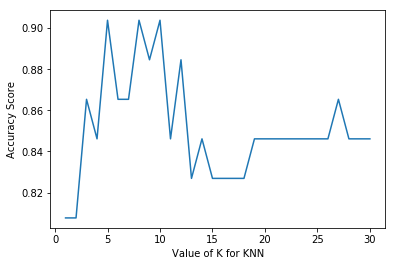

In [31]:
plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')

### Predict with different split size: 85-15 train-test split and k = 5

In [32]:
#create train and test dataset
X = np.array(vect_Reviews_df)
tpercent = 0.85
tsize = int(np.floor(tpercent * len(vect_Reviews_df)))
reviews_train_df = X[:tsize]
reviews_test_df = X[tsize:]

train_len = len(reviews_train_df)
test_len = len(reviews_test_df)

In [33]:
#Apply the KNN Algorithm
neighbor = NearestNeighbors(n_neighbors=3).fit(reviews_train_df)

#nearest k neighbors of each datapoint in object X
distances, indices = neighbor.kneighbors(reviews_train_df)

In [36]:
#2 related products based on mean rating
for i in range(test_len):
    h = neighbor.kneighbors([reviews_test_df[i]])
    related_product_list = h[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df_new["asin"][train_len + i] ," average rating is ",df_new["overall"][train_len + i])
    print ("The first similar product is ", df_new["asin"][first_related_product] ," average rating is ",df_new["overall"][first_related_product])
    print ("The second similar product is ", df_new["asin"][second_related_product] ," average rating is ",df_new["overall"][second_related_product])
    print ("****************************************************************************")

Based on product reviews, for  B00BYJXGP2  average rating is  4.132
The first similar product is  B00BW6GH76  average rating is  4.367424242424242
The second similar product is  B008DJIGR4  average rating is  4.310344827586207
****************************************************************************
Based on product reviews, for  B00C5SMPA8  average rating is  4.404580152671755
The first similar product is  B001UO651S  average rating is  3.8661417322834644
The second similar product is  B008LE7XD4  average rating is  4.4033613445378155
****************************************************************************
Based on product reviews, for  B00C96CD7G  average rating is  4.2594936708860756
The first similar product is  B004JQUZC4  average rating is  4.358333333333333
The second similar product is  B0065PGWQ0  average rating is  4.5576923076923075
****************************************************************************
Based on product reviews, for  B00C96CDBM  average rating is

In [37]:
train_target_df = df_new["overall"][:train_len]
test_target_df = df_new["overall"][train_len:train_len+test_len]
train_target_df = train_target_df.astype(int)
test_target_df = test_target_df.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(reviews_train_df, train_target_df)
knnpreds_test = knnclf.predict(reviews_test_df)

print(classification_report(test_target_df, knnpreds_test))

              precision    recall  f1-score   support

           3       0.50      0.33      0.40         3
           4       0.93      0.97      0.95        29

   micro avg       0.91      0.91      0.91        32
   macro avg       0.72      0.65      0.67        32
weighted avg       0.89      0.91      0.90        32



In [38]:
print (accuracy_score(test_target_df, knnpreds_test))

0.90625


In [39]:
print(mean_squared_error(test_target_df, knnpreds_test))

0.09375


### As we can see the accuracy score varies with K, so let's apply our model for a range of K to identify which value is better

In [40]:
k_range = range(1, 31)
k_score = []
k_mse = []
for k in k_range:
    knnclf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    knnclf.fit(reviews_train_df, train_target_df)
    knnpreds_test = knnclf.predict(reviews_test_df)
    k_score.append(accuracy_score(test_target_df, knnpreds_test))
    k_mse.append(mean_squared_error(test_target_df, knnpreds_test))
    #print("accuracy_score: " + str(accuracy_score(test_target_df, knnpreds_test)) + " for K=" + str(k))
    #print("mean_squared_error: " + str(mean_squared_error(test_target_df, knnpreds_test)))

Text(0, 0.5, 'Accuracy Score')

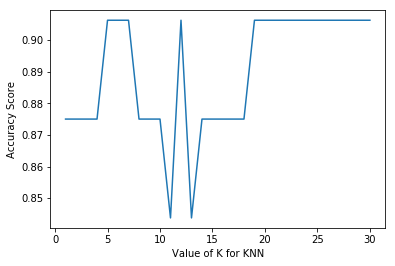

In [41]:
plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')

### By analysing both graph, the best accuracy is with common value of K = 5

## Conclusion:
We used the Item based collaborative approach with KNN model for our product recommendation system. The reason why we preferred item based approach over user based approach is because user based approach is often harder to evaluate because of the dynamic behavior of users, whereas items usually don’t change very often, and it can be computed offline and served without rigorous training of the model.

We predicted the rating score of the product by taking number of neighbors = 3 and test train split of 75-25. 
The accuracy of the model was 0.8653846153846154 and the MSE was 0.1346153846153846.

Then we predicted the rating score of the product by taking number of neighbors = 5 and test train split of 75-25. 
The accuracy of the model was 0.9038461538461539 and the MSE was 0.09615384615384616.

Further, we predicted the rating score of the product by taking n_neighbors = 5 and test train split of 85-15. 
The accuracy of the model was 0.90625 and the MSE was 0.09375.

So, our analysis says that changing the test train split size did not make much difference for model evaluation but changing the value of K (number of neighbors) did affect the model very much. Based on this dataset and the way KNN is implemented here, the best value for K would be 5.